In [4]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba) 
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)


working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/sorghum_bicolor"

# load arguments
#args <- commandArgs(T)
#if(length(args)!=5){stop("Rscript normGBA.R <gene.sparse> <meta> <Zea_mays.AGPv4.36.Allgene.nuclear.bed> <prefix> <F>")}
#input_data <- as.character(args[1])
#meta <- as.character(args[2])
#gene <- as.character(args[3])
#prefix <- as.character(args[4])



#gene_bodysorghum_bicolor_tis_leaf_nmf_step_2_knn_27.out.de_novo.rds
input <- here(working_dir,"00.data/sb.gene_accessability.iter_1.scores.txt")
#input_2 <- here("/home/jpm73279/r_script_dev/lw_plotting","zea_mays.normalized_gene_acc_scores.leaf_svd_knn_100_strict.GBaccessibility.sparse")
meta <- here(working_dir,"00.data/Sb.leaf_annot.V4.meta.final.txt")
gene <- here(working_dir,"00.data/Sb.leaf_markers_maize.all.bed")
gene_DA <- here(working_dir,"00.data/Sbicolorv5.1.gene.bed")
#prefix <- "TEST_SORGHUM_TEST"

meta_data <- read.delim(meta)
gene_markers <- read.delim(gene)
gene_markers <- gene_markers  %>%
    arrange(type)

all_markers <- gene_markers$geneID

raw_cpm_counts_all_genes <- read_delim(input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)

colnames(meta_data)

merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(v4_annotation_n, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
merged_meta_cpm_information_copied <- merged_meta_cpm_information
catch <- merged_meta_cpm_information_copied  %>%
    group_by(v4_annotation_n) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



caught_values <- as_tibble(catch)
see <- ungroup(merged_meta_cpm_information_copied)
merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
    rename(grouped_CPM = value)

Warning message in file(file, "rt"):
“cannot open file '/scratch/jpm73279/comparative_single_cell/08.annotation_figures/sorghum_bicolor/00.data/Sb.leaf_markers_maize.all.bed': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [ ]:
head(merged_meta_cpm_information_copied)

In [ ]:
head(merged_meta_cpm_information_copied)
altered_deseq2 <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -v4_annotation_n, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(v4_annotation_n)  %>% 
    mutate(Zscore_group = scale(Zscore))

In [ ]:
# Create Proportion Cells Accessible Metrics ------------------------------
merged_meta_cellID_values <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))
take_unq_genes <- unique(merged_meta_cellID_values$geneID)


merged_meta_cellID_values_all_genes <- merged_meta_cellID_values %>% 
    select(cellID, v4_annotation_n, accessability, geneID) 

In [ ]:
dim(merged_meta_cellID_values_all_genes)

In [ ]:
dim(unique(merged_meta_cellID_values_all_genes))

In [ ]:
merged_meta_cellID_values_all_genes  %>% 
    group_by(cellID, v4_annotation_n, accessability, geneID)  %>% 
    summarise(counts=n())  %>% 
    dplyr::filter(counts > 1)

In [ ]:
colnames(merged_meta_cellID_values_all_genes)
colnames(merged_meta_cellID_values_all_genes)

wider_all_genes_altered <- merged_meta_cellID_values_all_genes %>% 
                    distinct()  %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-v4_annotation_n, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability < 1 ~ 0,
                                                       accessability >= 1 ~ 1)) %>% 
                    group_by(v4_annotation_n, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))


#colnames(merged_meta_cellID_values_all_genes)
#merged_meta_cellID_values_all_genes %>% 
#    group_by(V3_annotation_n) %>% 
#    select(-accessability, -cellID) %>% 
#    unique() %>% 
#    summarise(count = n())

In [ ]:
### Updated DE-seq2 with only Well established Markers
good_marker_list <- c('pepc1', "cah1", "ssu1", "ssu2", "agp2", "me3", "sut1", "ccr1", "dct2", "mute",
                     "shr1_v4v5count_1", "sut7", 'sweet13a','sweet13b','sweet13c','sweet1b', "ba2", 
                      "cvp2", "fdl", "cvl2", "ad1", "gpat12", "acl1", "bm5", "fcp1", "ids1", "KCS1", 
                      "mdh6", "vt2","ZmAPL", "ZmSWEET11", "zyb14", "gpat11", "gpat12", "ocl5", "ocl4", 
                      "slac_v4v5count_1", "bhlh43", "dct2", "KCS1", "scr1", "ZmLAX2", "acl5", "pdf1", 
                      "pdf2", "ZmLRD3", "ad1", "ZmSMXL4_v4v5count_1", "SID1", "bk1_v4v5count_1", "ZmSMXL5")

good_gene_markers <- gene_markers  %>% 
    filter(name %in% good_marker_list)
head(good_gene_markers)

In [ ]:
### 7/23/2022 List of maarkers
good_marker_list <- c('pepc1', "cah1", "ssu2__ssu1", "ssu2", "agp2", "me3_ortho_count_1", 
                      "sut1__sut7", 
                      "dct2", "shr2h__shr2", "gl1", "ZmAAP6_4","ocl1",
                     "shr1_v4v5count_1", 'sweet13a','sweet13b','sweet13c','sweet1b', 
                      "cvp2", "fdl", "cvl2", "ad1", "ids1", "knox8",
                      "mdh6", "vt2","ZmAPL", "ZmSWEET11", "zyb14", "ocl5", "ocl4", "hkt1_2", "kch1",
                      "slac_v4v5count_1", "dct2", "scr1h__scr1", "ZmLAX2", "pdf1", "ZmOPL2",
                      "xcp1", "gpat12", "pdf1", "pdf2","snd1","dct2_ortho_count_1", "mute",
                      "pdf2", "ZmLRD3", "ad1", "ZmSMXL4_v4v5count_1", "ZmSMXL5")

good_gene_markers <- gene_markers  %>% 
    filter(name %in% good_marker_list)
head(good_gene_markers)

In [ ]:
marker_final_plotting <- left_join(altered_deseq2, wider_all_genes_altered, by = c("v4_annotation_n", "geneID")) %>% 
        left_join(., gene_markers, by = c("geneID"))

In [ ]:
test_marker_clust <- marker_final_plotting  %>% 
    filter(geneID %in% good_gene_markers$geneID)  %>% 
    ungroup() %>% 
    dplyr::select(v4_annotation_n, Zscore, name)  %>% 
    pivot_wider(names_from = v4_annotation_n, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying

In [ ]:
row.names(test_marker_clust) <- test_marker_clust$name  # put gene in `row`
test_marker_clust <- test_marker_clust[,-1] #drop gene column as now in rows
clust <- hclust(dist(test_marker_clust %>% as.matrix())) # hclust with distance matrix

In [ ]:
mat <- marker_final_plotting %>% 
    filter(geneID %in% good_gene_markers$geneID)  %>% 
    ungroup() %>% 
    dplyr::select(v4_annotation_n, Zscore, name)  %>% 
    pivot_wider(names_from = v4_annotation_n, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$name  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix

In [ ]:
options(repr.plot.width=8, repr.plot.height=10)


marker_final_plotting  %>% 
    mutate(Gene_name = factor(name, clust$labels[clust$order]),
          Cluster_name = factor(v4_annotation_n, levels = v_clust$labels[v_clust$order])) %>% 
    filter(is.na(Gene_name) != TRUE) %>% 
    ggplot(., aes(x=Cluster_name, y = Gene_name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1)) +
    ggtitle("Sb Z Score of Markers - Across Annotations")





In [3]:
marker_final_plotting  %>% 
    mutate(Gene_name = factor(name, clust$labels[clust$order]),
          Cluster_name = factor(v4_annotation_n, levels = v_clust$labels[v_clust$order])) %>% 
    filter(is.na(Gene_name) != TRUE) %>% 
    ggplot(., aes(y=Cluster_name, x = Gene_name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1)) +
    ggtitle("Sb Z Score of Markers - Across Annotations")


ERROR: Error in mutate(., Gene_name = factor(name, clust$labels[clust$order]), : object 'marker_final_plotting' not found


In [ ]:
ggsave("zm_selected_marker_dotplot.main_figure.pdf", plot = figure_marker_dotplot,
    path = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_1/dotplots",
    width = 10, height = 5,
    units = c('in'), limitsize = FALSE, dpi = 300)

In [45]:
### 7/23/2022 List of maarkers
good_marker_list <- c("Zm00001eb121470_pval_0_bundle_sheath_ncell_2870_ortho_count_1",                                                                                                      "Zm00001eb140540_pval_0_bundle_sheath_ncell_2870",                                                                                                                    "Zm00001eb108620_pval_0_bundle_sheath_ncell_2870",                                                                                                                    "Zm00001eb055880_pval_0_bundle_sheath_ncell_2870",                                                                                                                    "Zm00001eb144010_pval_0_bundle_sheath_ncell_2870",                                                                                                                    "Zm00001eb147960_pval_0_companion_cells_ncell_647",                                                                                                                   "Zm00001eb067750_pval_0_companion_cells_ncell_647",                                                                                                                   "Zm00001eb353280_pval_0_companion_cells_ncell_647__Zm00001eb293110_pval_0_companion_cells_ncell_647",                                                                 "Zm00001eb290460_pval_0_developing_mesophyll_ncell_494",                                                                                                              "Zm00001eb433610_pval_0_developing_mesophyll_ncell_494",                                                                                                              "Zm00001eb176880_pval_0_developing_mesophyll_ncell_494",                                                                                                              "Zm00001eb313510_pval_0_epidermal_ncell_3135",                                                                                                                        "Zm00001eb338800_pval_0_epidermal_ncell_3135",                                                                                                                        "Zm00001eb009780_pval_0_epidermal_ncell_3135",                                                                                                                        "Zm00001eb087570_pval_0_guard_cell_ncell_285",
"Zm00001eb287770_pval_0_mesophyll_ncell_4541",
"Zm00001eb158810_pval_0_mesophyll_ncell_4541",
"Zm00001eb383680_pval_0_mesophyll_ncell_4541",
"Zm00001eb172450_pval_0_mesophyll_ncell_4541",
"Zm00001eb059100_pval_0.053_metaphloem_sieve_element_ncell_114",
"Zm00001eb088790_pval_0_procambium_ncell_372",
"Zm00001eb408260_pval_0_procambium_ncell_372",
"Zm00001eb187760_pval_0_procambium_ncell_372",
"Zm00001eb095020_pval_0_procambium_ncell_372",
"Zm00001eb130080_pval_0_protoderm_ncell_1292",
"Zm00001eb084940_pval_0_protoderm_ncell_1292",
"Zm00001eb050930_pval_0_protoderm_ncell_1292",
"Zm00001eb325230_pval_0_protoderm_ncell_1292",
"Zm00001eb417150_pval_0_protoderm_ncell_1292",
"Zm00001eb158420_pval_0.0011_subsidary_cell_ncell_117",
"Zm00001eb080070_pval_0.0219_subsidary_cell_ncell_117",
"Zm00001eb354450_pval_0.0219_subsidary_cell_ncell_117",
"Zm00001eb161620_pval_0.0249_subsidary_cell_ncell_117",
"Zm00001eb288410_pval_0.0425_subsidary_cell_ncell_117",
"Zm00001eb235530_pval_0_unknown_ncell_574",
"Zm00001eb300760_pval_0_unknown_ncell_574",
"Zm00001eb368810_pval_0_unknown_ncell_574",
"Zm00001eb428870_pval_0_unknown_ncell_574",
"Zm00001eb280280_pval_0_vascular_parenchyma_ncell_1231",
"Zm00001eb318210_pval_0_vascular_parenchyma_ncell_1231",
"Zm00001eb154590_pval_0_vascular_parenchyma_ncell_1231",
"Zm00001eb126710_pval_0_xylem_ncell_336",
"Zm00001eb243520_pval_0_xylem_ncell_336",
"Zm00001eb303780_pval_0_xylem_ncell_336",
"Zm00001eb173670_pval_0_xylem_ncell_336",
"Zm00001eb282610_pval_0_xylem_ncell_336")

good_gene_markers <- gene_markers  %>% 
    filter(name %in% good_marker_list)


marker_final_plotting <- left_join(altered_deseq2, wider_all_genes_altered, by = c("v4_annotation_n", "geneID")) %>% 
        left_join(., gene_markers, by = c("geneID"))

test_marker_clust <- marker_final_plotting  %>% 
    filter(geneID %in% good_gene_markers$geneID)  %>% 
    ungroup() %>% 
    dplyr::select(v4_annotation_n, Zscore, name)  %>% 
    pivot_wider(names_from = v4_annotation_n, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying

row.names(test_marker_clust) <- test_marker_clust$name  # put gene in `row`
test_marker_clust <- test_marker_clust[,-1] #drop gene column as now in rows
clust <- hclust(dist(test_marker_clust %>% as.matrix())) # hclust with distance matrix

mat <- marker_final_plotting %>% 
    filter(geneID %in% good_gene_markers$geneID)  %>% 
    ungroup() %>% 
    dplyr::select(v4_annotation_n, Zscore, name)  %>% 
    pivot_wider(names_from = v4_annotation_n, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$name  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix

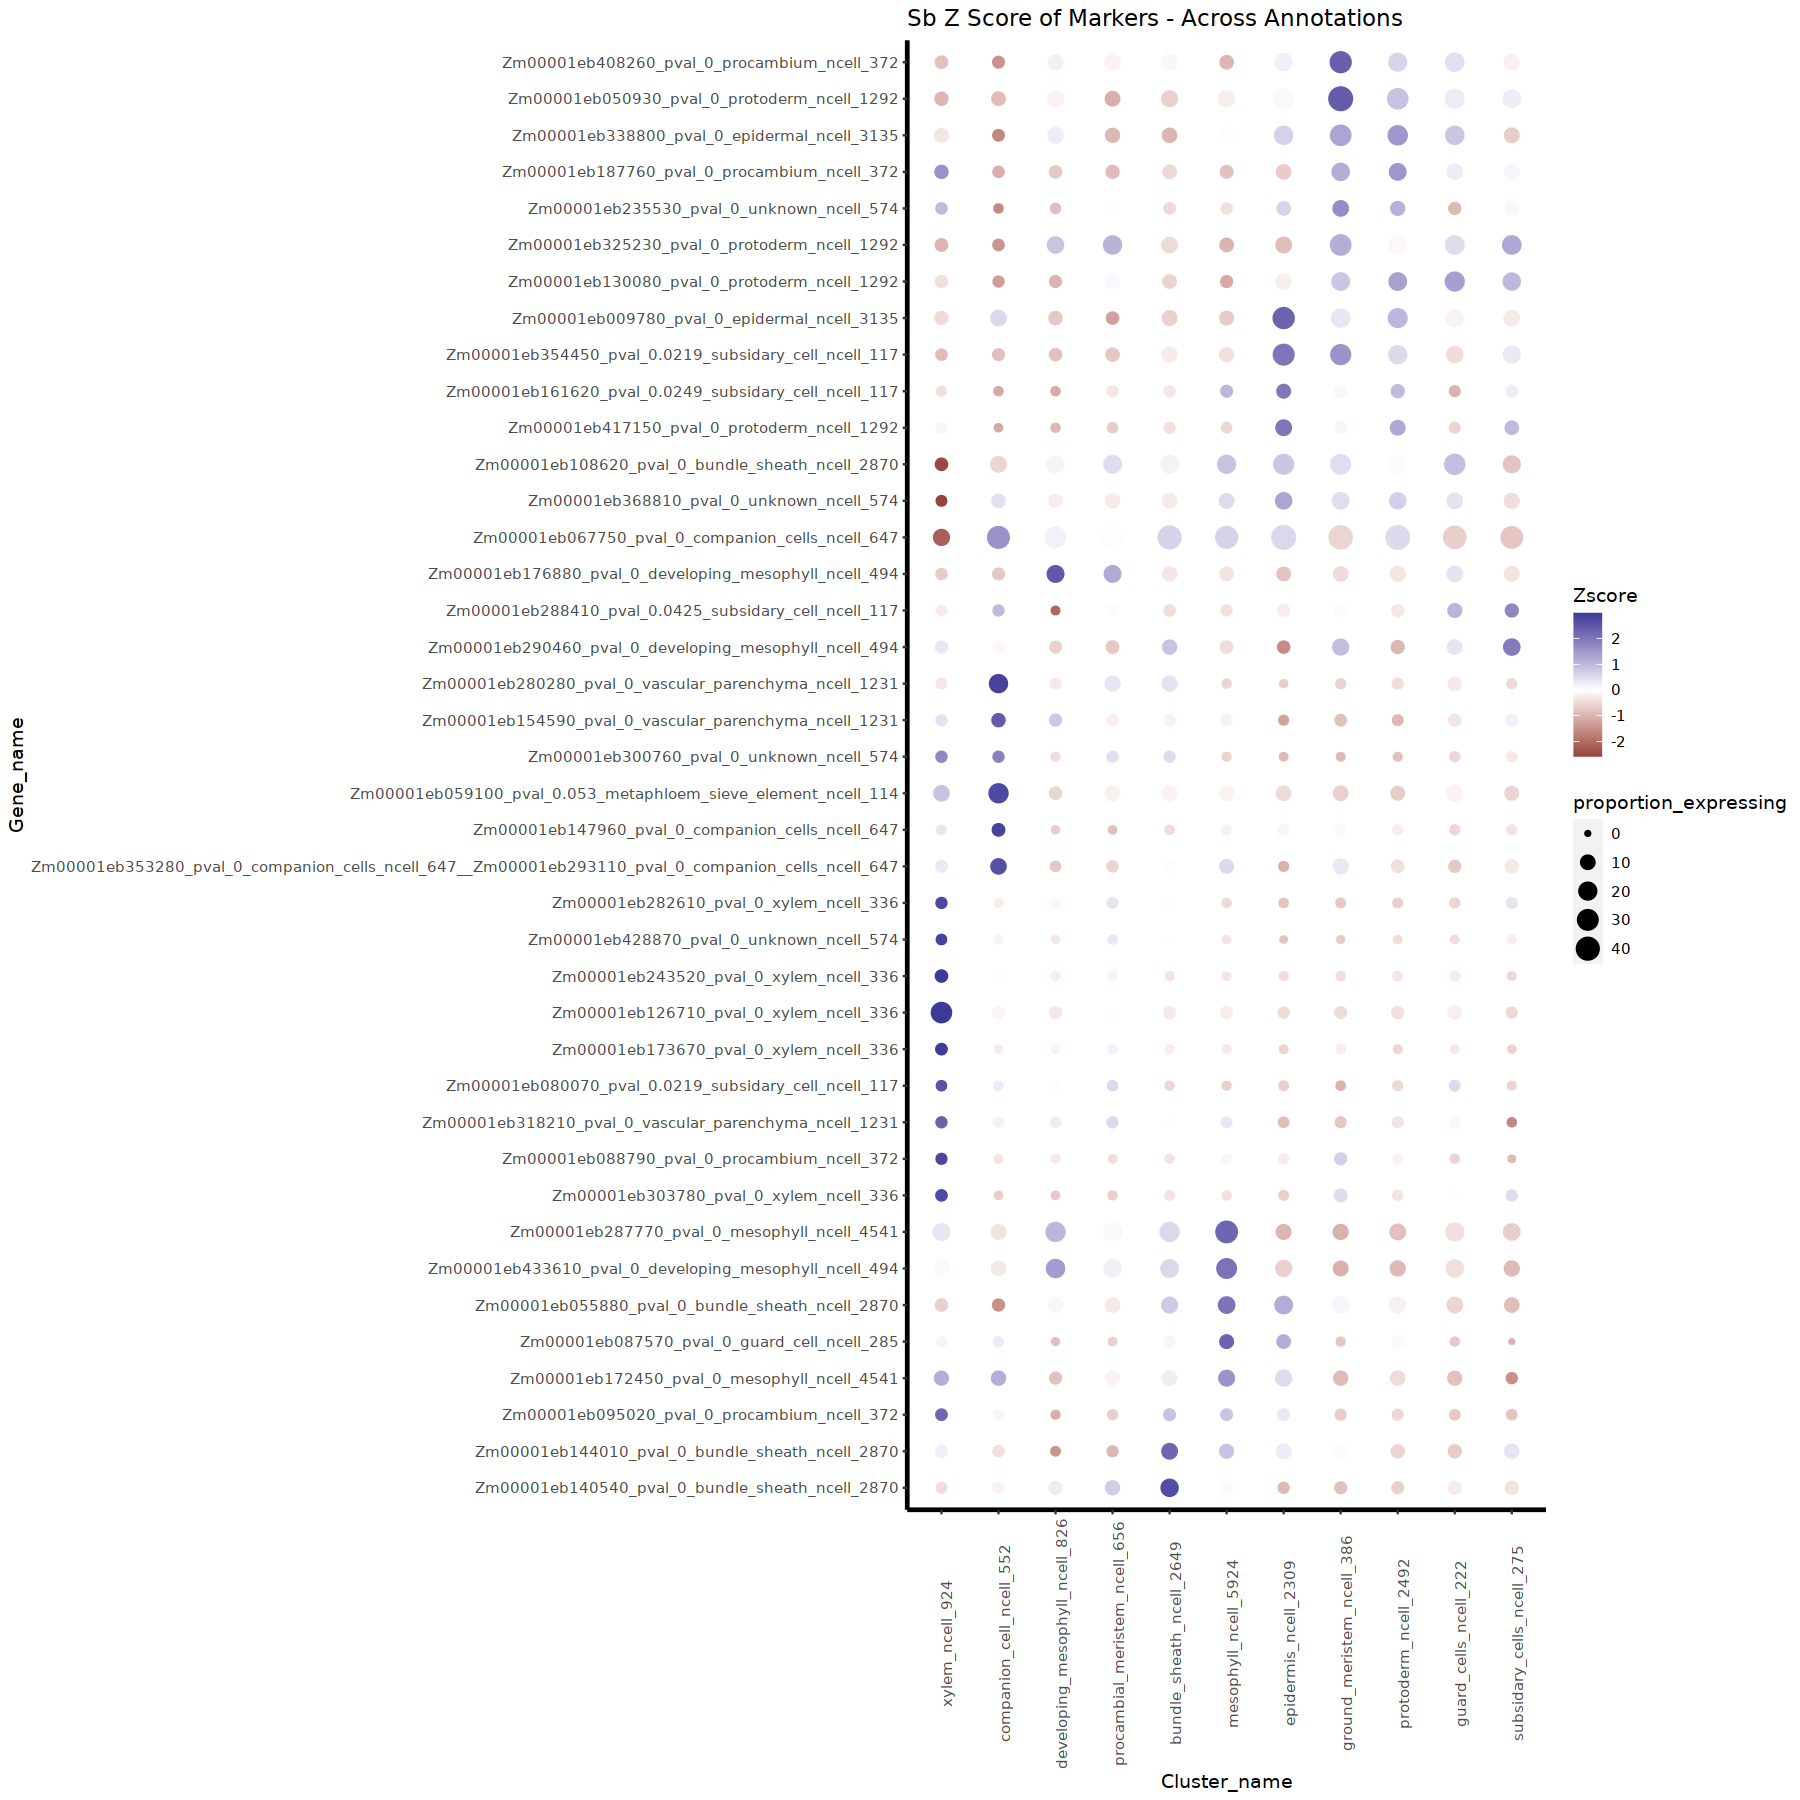

In [46]:
options(repr.plot.width=15, repr.plot.height=15)
marker_final_plotting  %>% 
    mutate(Gene_name = factor(name, clust$labels[clust$order]),
          Cluster_name = factor(v4_annotation_n, levels = v_clust$labels[v_clust$order])) %>% 
    filter(is.na(Gene_name) != TRUE) %>% 
    ggplot(., aes(x=Cluster_name, y = Gene_name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1)) +
    ggtitle("Sb Z Score of Markers - Across Annotations")

In [50]:
options(repr.plot.width=15, repr.plot.height=15)
marker_final_plotting  %>% 
    filter(name %in% good_marker_list)  %>% 
    arrange(name)  %>% 
    ggplot(., aes(x=v4_annotation_n, y = name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1)) +
    ggtitle("Sb Z Score of Markers - Across Annotations")

ERROR: Error in sort(., name): object 'name' not found
